In [ ]:
%pip install shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from sklearn.tree import export_graphviz
from graphviz import Source
import numpy as np
import optuna
from xgboost import XGBRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from statsmodels.tsa.stattools import acf
from sklearn.tree import export_graphviz
from graphviz import Source
import torch.optim as optim
import shap

### Prepare data

In [2]:
tr_1 = pd.read_csv("../data/raw/transactions_1.csv", index_col=0)
tr_2 = pd.read_csv("../data/raw/transactions_2.csv", index_col=0)
tr_total = pd.concat([tr_1, tr_2], axis = 0).sort_values(by = ["date"])
tr_total = tr_total.drop_duplicates()


NameError: name 'pd' is not defined

In [7]:
tr_1['date'] = pd.to_datetime(tr_1['date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

In [1]:
tr_1.sort_values("date")

NameError: name 'tr_1' is not defined

In [196]:
# convert date column to datetime
tr_total['date'] = pd.to_datetime(tr_total['date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
tr_total['year_month'] = tr_total['date'].dt.to_period('M') 
monthly_data = tr_total.groupby(['customer_id', 'year_month'])['product_id'].count().reset_index().rename(columns = {"product_id" : "transactions"})

In [197]:
all_dates = pd.period_range(start=monthly_data['year_month'].min(),
                            end=monthly_data['year_month'].max(),
                            freq='M')

all_combinations = pd.MultiIndex.from_product(
    [monthly_data['customer_id'].unique(), all_dates],
    names=['customer_id', 'year_month']
).to_frame(index=False)

# Merge with the original data to fill in missing months
complete_data = all_combinations.merge(monthly_data, on=['customer_id', 'year_month'], how='left')
complete_data['transactions'] = complete_data['transactions'].fillna(0)

In [198]:
complete_data.tail()

,customer_id,year_month,transactions
78073,9997881,2019-11,0.0
78074,9997881,2019-12,2.0
78075,9997881,2020-01,0.0
78076,9997881,2020-02,0.0
78077,9997881,2020-03,0.0


<Axes: xlabel='year_month'>

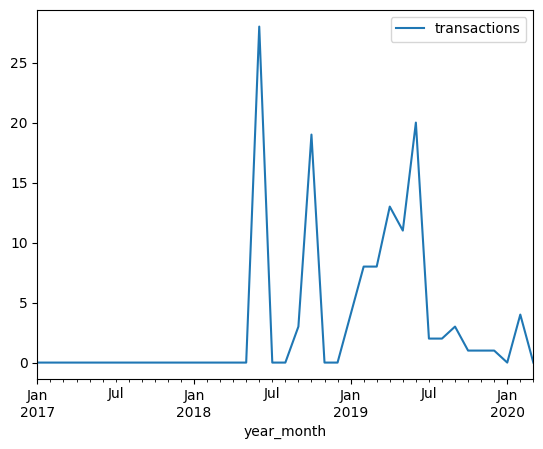

In [199]:
complete_data[complete_data["customer_id"] == 1001614].plot("year_month", "transactions")

<Axes: xlabel='year_month'>

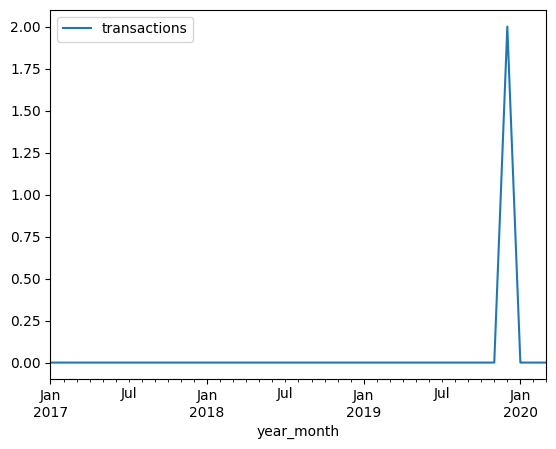

In [200]:
complete_data[complete_data["customer_id"] == 9997881].plot("year_month", "transactions")

In [201]:
# Create lagged features for 1 to 12 months
for lag in range(1, 13):
    complete_data[f'1_month_transactions_lag_{lag}'] = complete_data.groupby('customer_id')['transactions'].shift(lag).fillna(0.0)

In [202]:
from tqdm.notebook import tqdm
window_size = 3
targets = []
lagged_monthly_transactions = [f"1_month_transactions_lag_{i}" for i in range(1, 21)]

for customer_id in tqdm(complete_data['customer_id'].unique()):
    customer_data = complete_data[complete_data['customer_id'] == customer_id]
    
    for i in range(len(customer_data) - window_size + 1):
        target_sum = customer_data['transactions'].iloc[i:i+window_size].sum()
        lagged_transactions = complete_data[complete_data['customer_id'] == customer_id].iloc[i].drop(['transactions', 'year_month']).to_dict()
        
        targets.append({
            'customer_id': customer_id,
            'start_year': customer_data['year_month'].iloc[i].year,
            'start_month': customer_data['year_month'].iloc[i].month,
            'end_year': customer_data['year_month'].iloc[i+window_size-1].year,
            'end_month': customer_data['year_month'].iloc[i+window_size-1].month,
            'transactions': target_sum,
            **lagged_transactions
        })

targets_df = pd.DataFrame(targets)
targets_df = targets_df.sort_values(by=['customer_id', 'start_year', 'start_month'])

  0%|          | 0/2002 [00:00<?, ?it/s]

In [203]:
for lag in range(3, 13, 3):
    targets_df[f'3_month_transactions_lag_{lag}'] = targets_df.groupby('customer_id')['transactions'].shift(lag).fillna(0)

In [205]:
targets_df.tail(5)

,customer_id,start_year,start_month,end_year,end_month,transactions,1_month_transactions_lag_1,1_month_transactions_lag_2,1_month_transactions_lag_3,1_month_transactions_lag_4,...,1_month_transactions_lag_7,1_month_transactions_lag_8,1_month_transactions_lag_9,1_month_transactions_lag_10,1_month_transactions_lag_11,1_month_transactions_lag_12,3_month_transactions_lag_3,3_month_transactions_lag_6,3_month_transactions_lag_9,3_month_transactions_lag_12
74069,9997881,2019,9,2019,11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74070,9997881,2019,10,2019,12,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74071,9997881,2019,11,2020,1,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74072,9997881,2019,12,2020,2,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74073,9997881,2020,1,2020,3,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


### transactions lags 

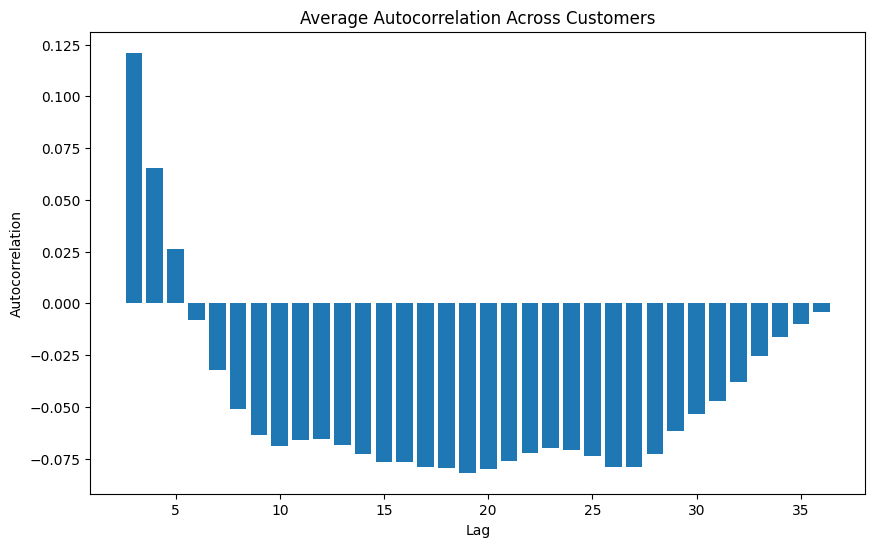

In [206]:
autocorrelations = []
nlags = 40

# Group by customer_id and calculate autocorrelation for each customer
for customer, group in targets_df.groupby('customer_id'):
    transactions = group['transactions'].values
    if len(transactions) > 1: 
        acf_values = acf(transactions, nlags=nlags, fft=False)  # Calculate ACF for the first lags
        autocorrelations.append(acf_values)

# Average autocorrelation across customers
average_autocorrelation = np.mean(autocorrelations, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(3, len(average_autocorrelation), 1), average_autocorrelation[3::1])
plt.title('Average Autocorrelation Across Customers')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

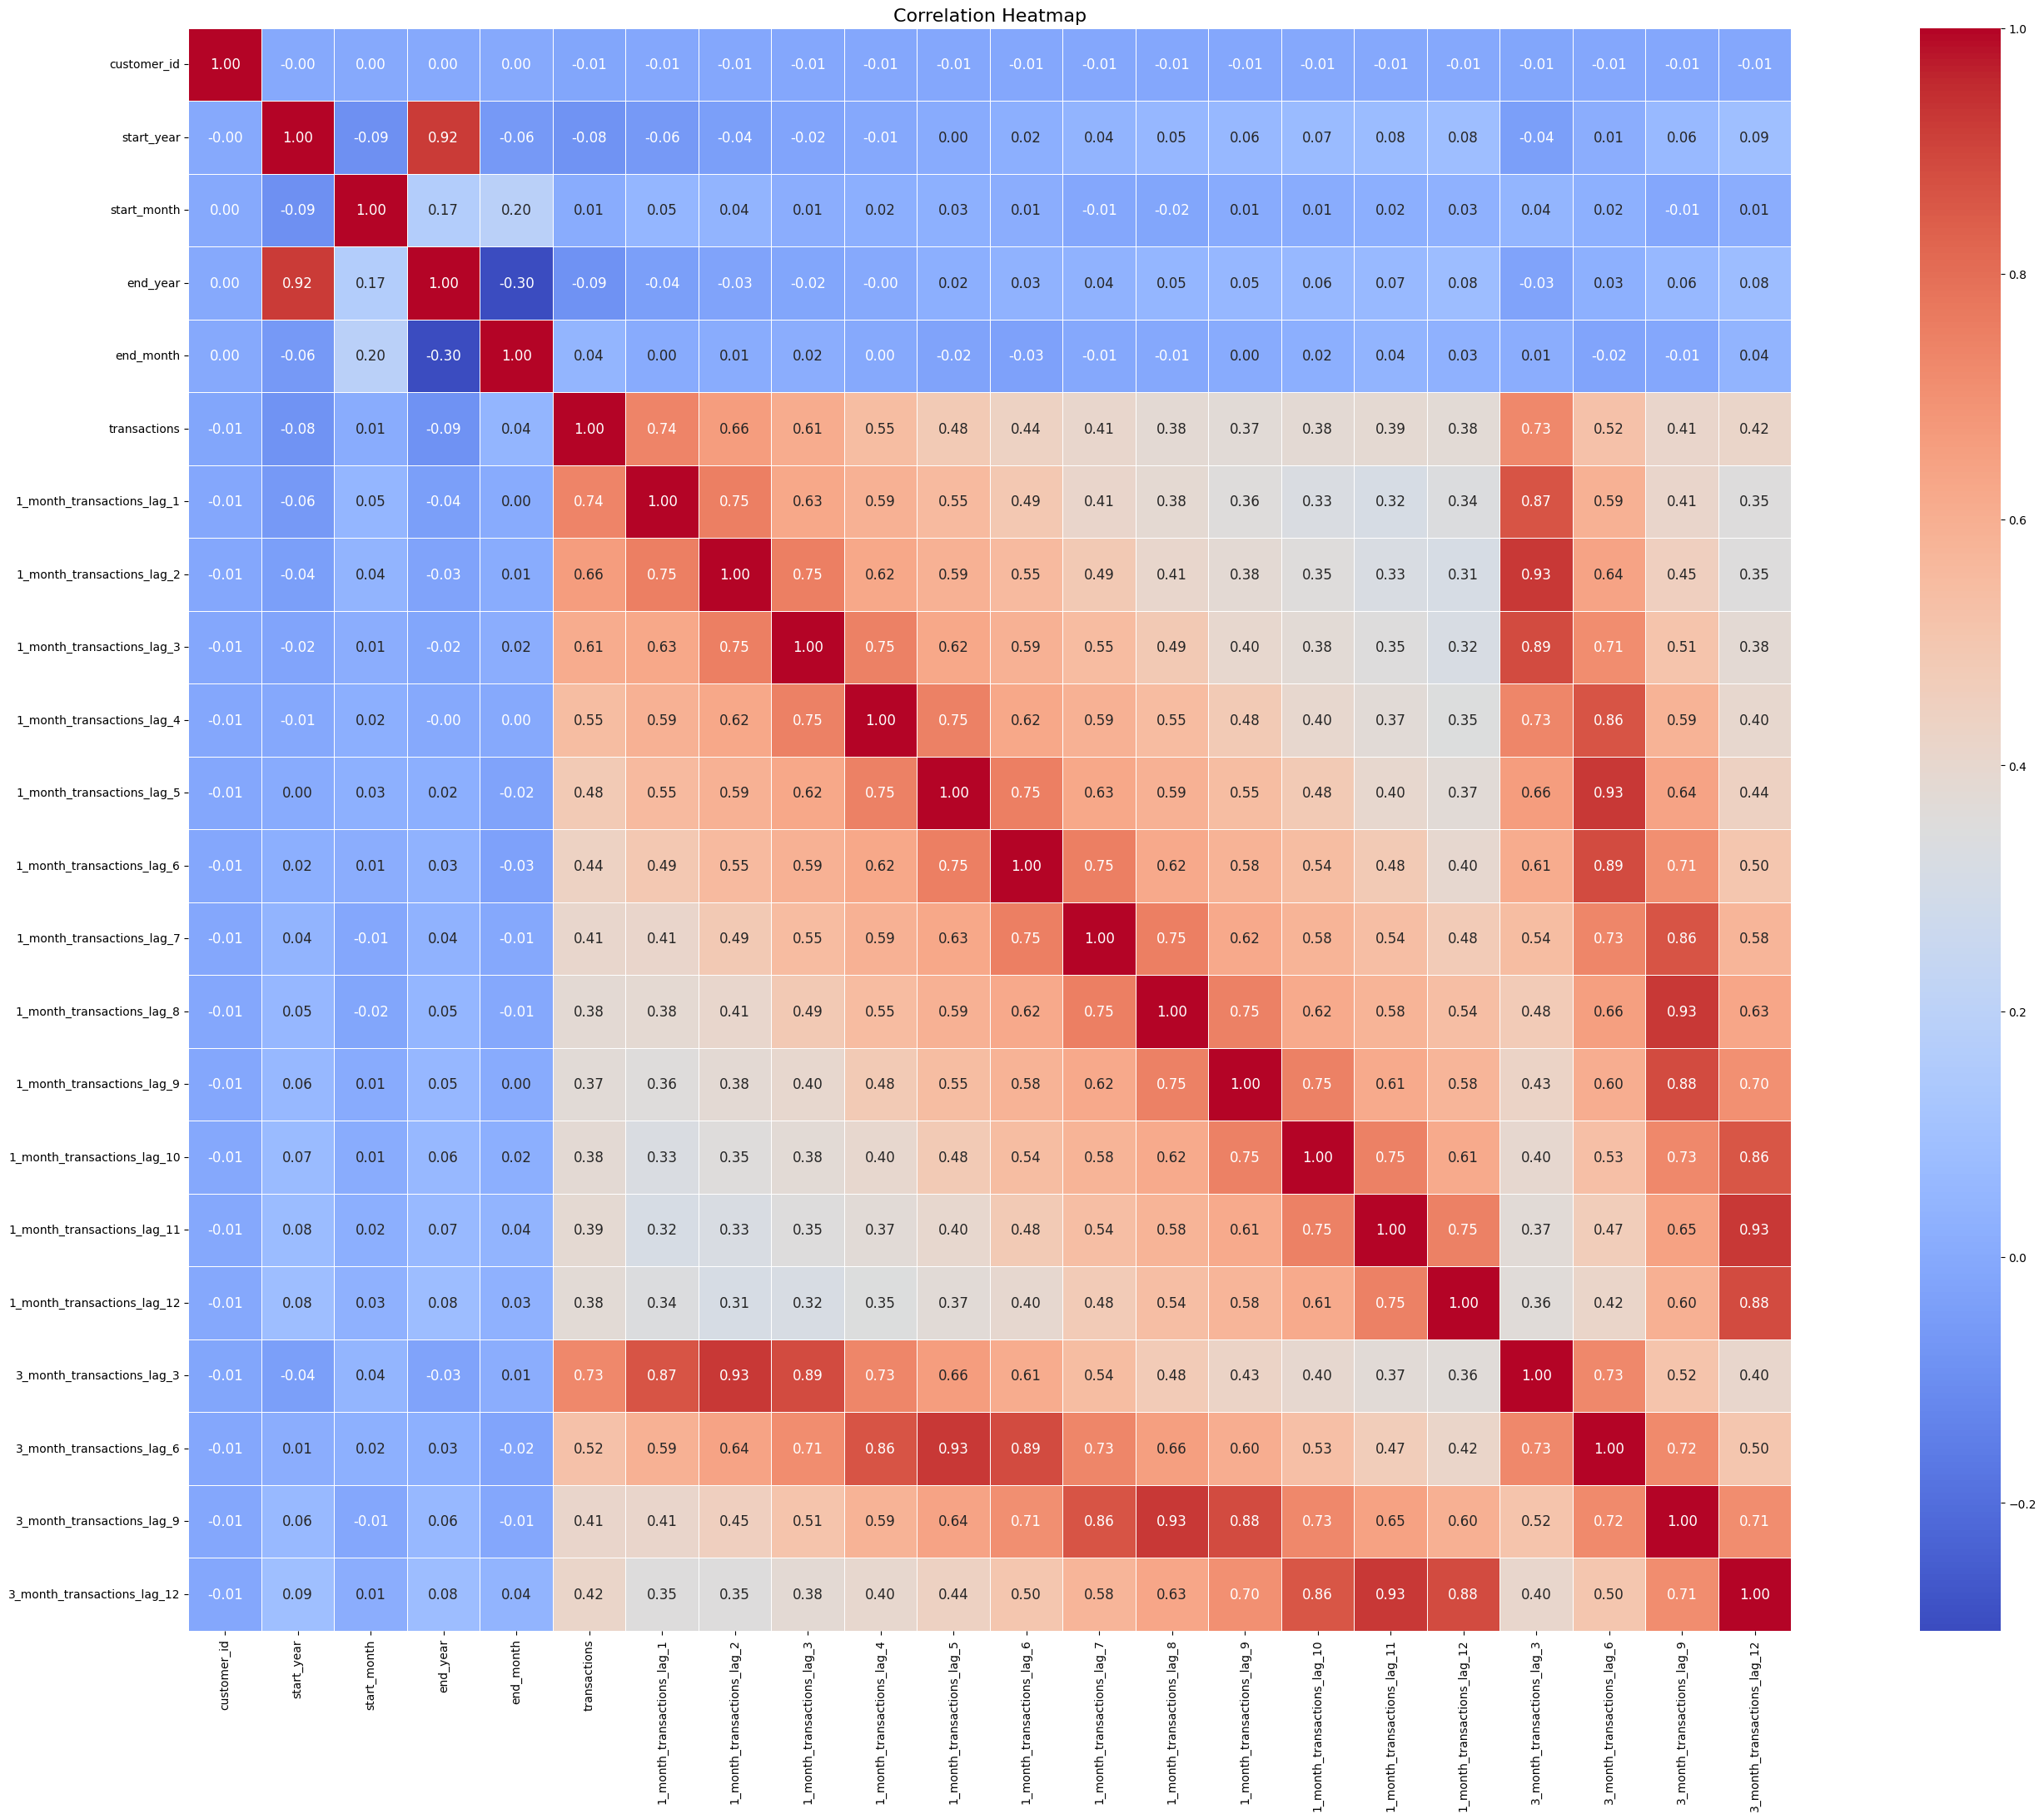

In [207]:
plt.figure(figsize=(40, 25))

# Create the heatmap with annotations
sns.heatmap(
    targets_df.corr(), 
    annot=True,        
    fmt=".2f",          
    cmap="coolwarm",    
    annot_kws={"size": 12}, 
    linewidths=0.5,     
    square=True         
)

plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### Train/test split

In [208]:
train_year = 2019
train_month = 1

train = targets_df[
    (targets_df['end_year'] < train_year) |
    ((targets_df['end_year'] == train_year) & (targets_df['end_month'] <= train_month))
]

test = targets_df[
    (targets_df['start_year'] == train_year) &
    (targets_df['start_month'] == train_month + 1)
]

In [126]:
train.columns, train.shape, test.shape

(Index(['customer_id', 'start_year', 'start_month', 'end_year', 'end_month',
        'transactions', '1_month_transactions_lag_1',
        '1_month_transactions_lag_2', '1_month_transactions_lag_3',
        '1_month_transactions_lag_4', '1_month_transactions_lag_5',
        '1_month_transactions_lag_6', '1_month_transactions_lag_7',
        '1_month_transactions_lag_8', '1_month_transactions_lag_9',
        '1_month_transactions_lag_10', '1_month_transactions_lag_11',
        '1_month_transactions_lag_12', '1_month_transactions_lag_13',
        '1_month_transactions_lag_14', '1_month_transactions_lag_15',
        '1_month_transactions_lag_16', '1_month_transactions_lag_17',
        '1_month_transactions_lag_18', '1_month_transactions_lag_19',
        '1_month_transactions_lag_20'],
       dtype='object'),
 (46046, 26),
 (2002, 26))

In [209]:
# Features and target for training
X_train = train.drop(columns=['transactions'])
y_train = train['transactions']

# Features and target for testing
X_test = test.drop(columns=['transactions'])
y_test = test['transactions']

In [210]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((46046, 21), (46046,), (2002, 21), (2002,))

### Benchmark

* mean of previous customer transactions
* Previous three months transactions 

In [212]:
mean_transactions = train.groupby('customer_id')['transactions'].mean().reset_index()
mean_transactions.rename(columns={'transactions': 'mean_transactions'}, inplace=True)
test_with_mean = test.merge(mean_transactions, on='customer_id', how='left')

In [213]:
y_pred_benchmark = test_with_mean['mean_transactions']

# Compute evaluation metrics for the benchmark
mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)

# Print the benchmark results
print("Benchmark Results (Mean Prediction):")
print(f"Mean Absolute Error (MAE): {mae_benchmark:.2f}")

Benchmark Results (Mean Prediction):
Mean Absolute Error (MAE): 32.38


In [214]:
last_train_values = train[(train["end_year"] == 2019) & (train["end_month"] == 1)]["transactions"]

# Compute evaluation metrics for the benchmark
mae_benchmark_2 = mean_absolute_error(y_test, last_train_values)

# Print the benchmark results
print("Benchmark Results (Mean Prediction):")
print(f"Mean Absolute Error (MAE): {mae_benchmark_2:.2f}")

Benchmark Results (Mean Prediction):
Mean Absolute Error (MAE): 31.37


### Feature selection

In [218]:
train_year = 2018
train_month = 10

# Split the data based on time - use training data until June 2018 and validation data from July 2018
train_2 = train[
    (train['end_year'] < train_year) |
    ((train['end_year'] == train_year) & (train['end_month'] <= train_month))
]

valid_2 = train[
    (train['start_year'] > train_year) |
    ((train['start_year'] == train_year) & (train['start_month'] > train_month))
]

# Features and target for training
X_train_2 = train_2.drop(columns=['transactions'])
y_train_2 = train_2['transactions']

# Features and target for testing
X_val = valid_2.drop(columns=['transactions'])
y_val = valid_2['transactions']

In [219]:
X_train_2.shape, y_train_2.shape, X_val.shape, y_val.shape

((40040, 21), (40040,), (2002, 21), (2002,))

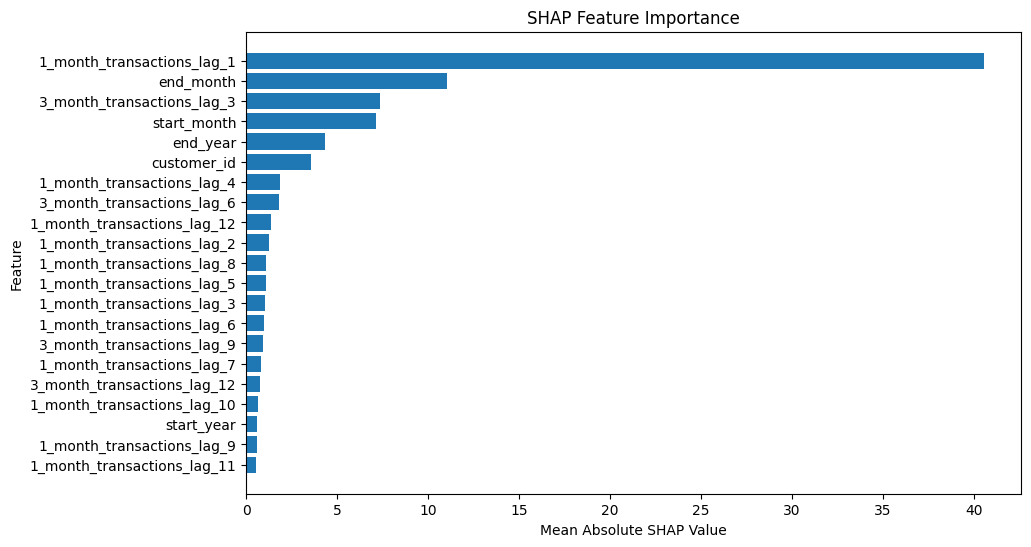

Test set R^2 score: 0.5531


In [220]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train_2, y_train_2)

# Use SHAP to explain the model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_val)

# Compute mean absolute SHAP value for each feature
shap_importance_df = pd.DataFrame({
    'feature': X_train_2.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

# Plot SHAP feature importance
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df['feature'], shap_importance_df['mean_abs_shap'])
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Select top 10 features
selected_features = shap_importance_df['feature'][:10]

# Train a new RandomForest model with selected features
rf_final = RandomForestRegressor(n_estimators=10, random_state=42)
rf_final.fit(X_train_2[selected_features], y_train_2)
test_score = rf_final.score(X_val[selected_features], y_val)
print(f"Test set R^2 score: {test_score:.4f}")

In [307]:
selected_features = X_train.columns
X_train_selected = X_train.loc[:, selected_features].reset_index(drop = True)
X_test_selected = X_test.loc[:, selected_features].reset_index(drop = True)

### Ridge regression

In [308]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train_selected, y_train)
y_train_pred = ridge.predict(X_train_selected)
y_test_pred = ridge.predict(X_test_selected)

y_train_pred = np.clip(y_train_pred, 0, None)
y_test_pred = np.clip(y_test_pred, 0, None)

# Calculate MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("Training Results:")
print(f"MAE: {train_mae:.7f}")

print("Testing Results:")
print(f"MAE: {test_mae:.7f}")

Training Results:
MAE: 37.7347350
Testing Results:
MAE: 21.8217623


In [230]:
pd.concat([X_test, pd.Series(y_test, name = "test"), pd.Series(y_test_pred,  index=X_test.index, name="predictions"), abs(y_test - y_test_pred)], axis = 1).rename(columns = {"transactions" : "error"}).sort_values("error", ascending=False)

,customer_id,start_year,start_month,end_year,end_month,1_month_transactions_lag_1,1_month_transactions_lag_2,1_month_transactions_lag_3,1_month_transactions_lag_4,1_month_transactions_lag_5,...,1_month_transactions_lag_10,1_month_transactions_lag_11,1_month_transactions_lag_12,3_month_transactions_lag_3,3_month_transactions_lag_6,3_month_transactions_lag_9,3_month_transactions_lag_12,test,predictions,error
42205,6026638,2019,2,2019,4,969.0,259.0,613.0,988.0,242.0,...,38.0,171.0,114.0,1841.0,1393.0,596.0,323.0,402.0,1721.606831,1319.606831
32807,4893343,2019,2,2019,4,130.0,239.0,32.0,239.0,108.0,...,19.0,13.0,89.0,401.0,452.0,222.0,121.0,1431.0,258.798520,1172.201480
2319,1242611,2019,2,2019,4,703.0,459.0,656.0,785.0,981.0,...,874.0,716.0,590.0,1818.0,2889.0,3138.0,2180.0,2468.0,1520.353423,947.646577
5131,1618902,2019,2,2019,4,789.0,435.0,873.0,689.0,493.0,...,2.0,68.0,302.0,2097.0,1347.0,634.0,372.0,819.0,1623.032501,804.032501
42649,6096036,2019,2,2019,4,561.0,683.0,429.0,460.0,222.0,...,24.0,37.0,25.0,1673.0,774.0,419.0,86.0,444.0,1159.292604,715.292604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46571,6574975,2019,2,2019,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
46608,6579199,2019,2,2019,4,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.000000
46682,6593523,2019,2,2019,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
46756,6606571,2019,2,2019,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


<Axes: xlabel='year_month'>

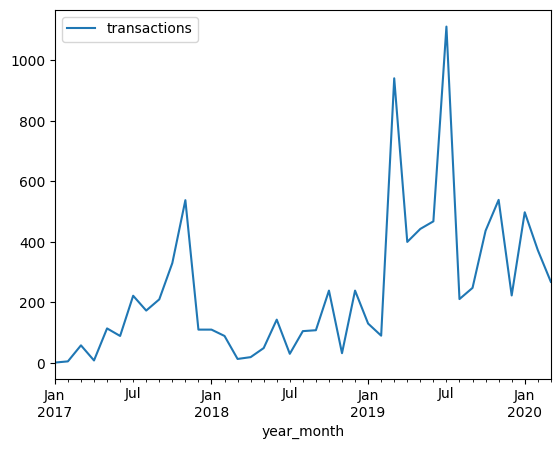

In [231]:
complete_data[complete_data["customer_id"] == 4893343].plot("year_month", "transactions")

<Axes: xlabel='year_month'>

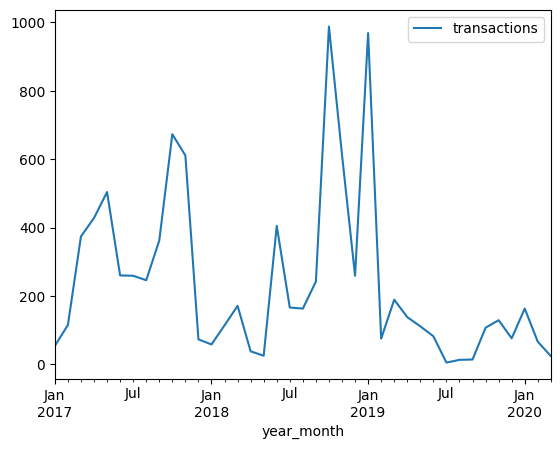

In [232]:
complete_data[complete_data["customer_id"] == 6026638].plot("year_month", "transactions")

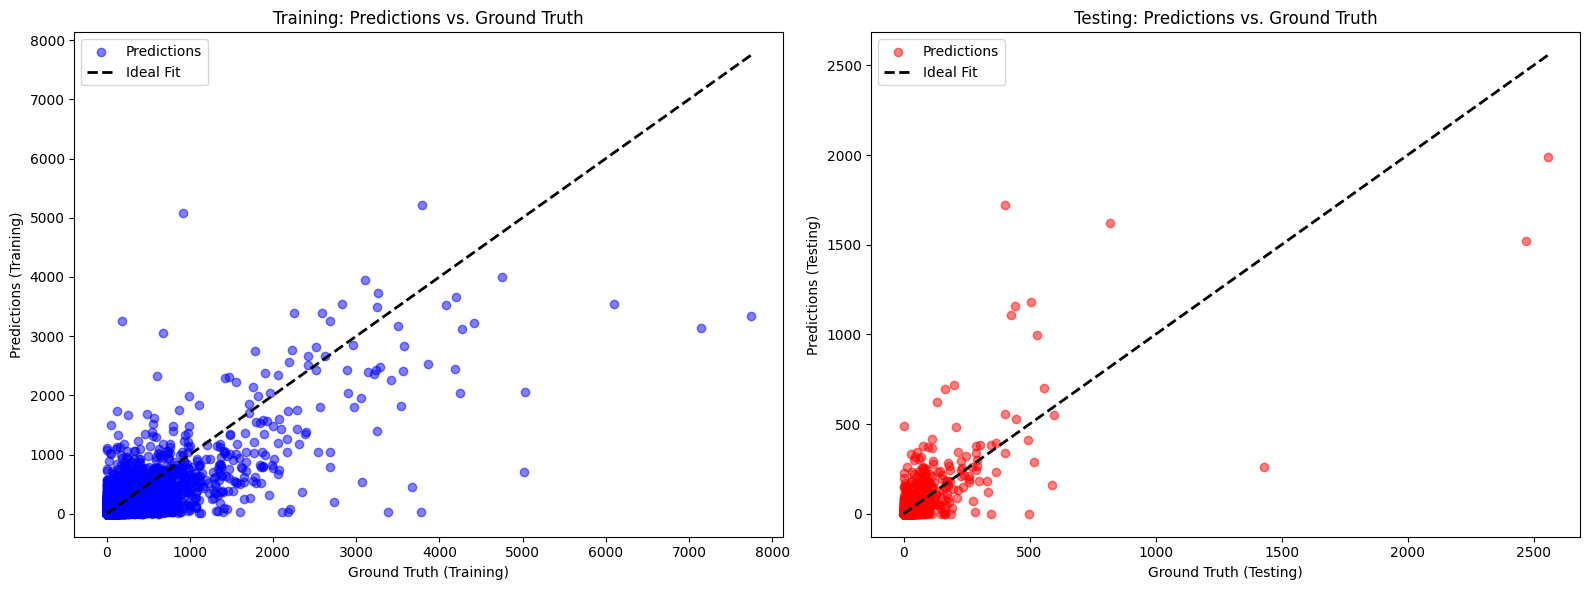

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_train, y_train_pred, alpha=0.5, color='blue', label='Predictions')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2, label='Ideal Fit')
ax1.set_xlabel("Ground Truth (Training)")
ax1.set_ylabel("Predictions (Training)")
ax1.set_title("Training: Predictions vs. Ground Truth")
ax1.legend()

ax2.scatter(y_test, y_test_pred, alpha=0.5, color='red', label='Predictions')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
ax2.set_xlabel("Ground Truth (Testing)")
ax2.set_ylabel("Predictions (Testing)")
ax2.set_title("Testing: Predictions vs. Ground Truth")
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Random Forest

In [234]:
X_train_selected.shape, X_test_selected.shape

((46046, 21), (2002, 21))

In [235]:
model = RandomForestRegressor(
            criterion="absolute_error",
            n_estimators = 80,
            max_depth = 5,
            max_features="sqrt",
            min_samples_split = 2,
            n_jobs = -1,
            random_state=42,
            verbose = 1,
        )

model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}") # 16.32 with 100, 16.4 with 120

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min


Training MAE: 30.9642
Test MAE: 17.2207


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


In [236]:
model.feature_importances_

array([0.00329147, 0.0004093 , 0.01196112, 0.00581882, 0.02224029,
       0.25669641, 0.15334954, 0.09641702, 0.0483882 , 0.0244593 ,
       0.01565721, 0.00696827, 0.0067222 , 0.00386205, 0.00607749,
       0.01091054, 0.02024122, 0.22184746, 0.04450995, 0.01473041,
       0.02544171])

In [238]:
most_important_tree_index = np.argmax([tree.tree_.impurity[0] for tree in model.estimators_])
most_important_tree = model.estimators_[most_important_tree_index]

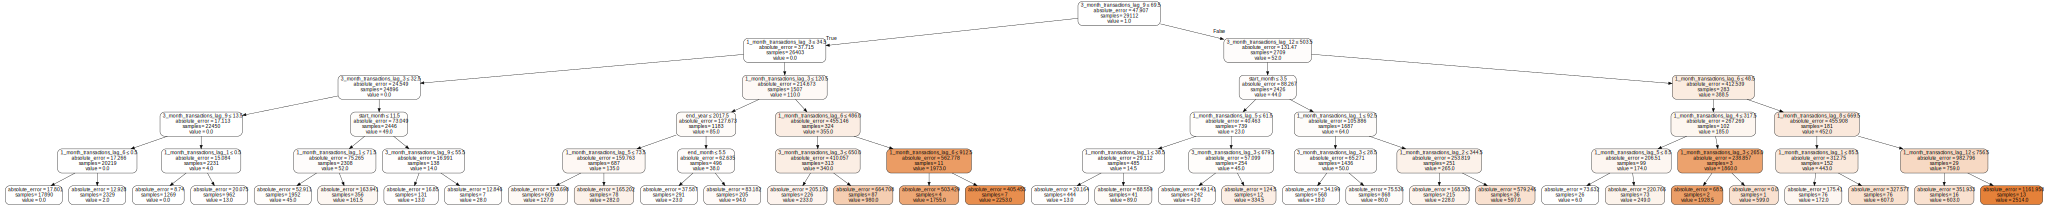

In [239]:
# Visualize the most important tree
tree_dot = export_graphviz(
    most_important_tree,
    out_file=None,
    feature_names=X_train_selected.columns,
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=True
)

# Render and display the tree inline in the notebook
graph = Source(tree_dot)
graph  # This will display the tree directly in the notebook


### Boost models

In [312]:
def objective(trial):
    # Sample hyperparameters
    params = {
        'objective': "reg:absoluteerror",  # Use custom MAE objective with alpha
        'eval_metric': 'mae',  # Mean absolute error metric for evaluation
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log = True),
        'tree_method': 'hist',  # Use 'hist' for faster training, or 'gpu_hist' for GPU acceleration
        'device': 'cuda',  # Use GPU if available
        'n_jobs': -1,
        'random_state': 42,
    }
    num_boost_round = trial.suggest_int('num_boost_round', 5, 50)
    mae_scores = []  # To store MAE scores for each fold

    n_customers = X_train_selected["customer_id"].nunique()
    
    date_count = X_train_selected.shape[0] // n_customers 
    
    for fold in range(1, 6) :
        
        train_idx = [date_idx+customer*date_count for customer in range(n_customers) for date_idx in range(date_count-fold)]
        val_idx = [date_idx+customer*date_count for customer in range(n_customers) for date_idx in range(date_count-fold, date_count)]
        
        X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model_xgb = XGBRegressor(
            **params,
            n_estimators=num_boost_round,  
        )
        model_xgb.fit(X_train_fold, y_train_fold)
        y_val_pred = model_xgb.predict(X_val_fold)
    
        mae = mean_absolute_error(y_val_fold, y_val_pred)
        mae_scores.append(mae)
    # Return the mean MAE across all folds
    return np.mean(mae_scores) 

# Create a study object and optimize it
study = optuna.create_study(direction='minimize')  # Minimize MAE
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters found
print(f"Best Hyperparameters: {study.best_params}")

[I 2025-01-27 15:59:15,010] A new study created in memory with name: no-name-82a0d6d1-63c2-4aab-8fd5-3944a0a2cfed
[I 2025-01-27 15:59:15,512] Trial 0 finished with value: 46.03792297710389 and parameters: {'max_depth': 7, 'colsample_bytree': 0.5710477369403193, 'min_child_weight': 7, 'learning_rate': 0.004379956126718927, 'num_boost_round': 5}. Best is trial 0 with value: 46.03792297710389.
[I 2025-01-27 15:59:16,217] Trial 1 finished with value: 11190.45038645955 and parameters: {'max_depth': 6, 'colsample_bytree': 0.5385111757720882, 'min_child_weight': 6, 'learning_rate': 2.6146724826989036, 'num_boost_round': 19}. Best is trial 0 with value: 46.03792297710389.
[I 2025-01-27 15:59:16,927] Trial 2 finished with value: 1.1282005613880019e+18 and parameters: {'max_depth': 3, 'colsample_bytree': 0.6271805938440771, 'min_child_weight': 8, 'learning_rate': 4.418981909343385, 'num_boost_round': 32}. Best is trial 0 with value: 46.03792297710389.
[I 2025-01-27 15:59:18,362] Trial 3 finished

Best Hyperparameters: {'max_depth': 7, 'colsample_bytree': 0.5167227122949185, 'min_child_weight': 6, 'learning_rate': 0.19308985065150314, 'num_boost_round': 38}


In [313]:
# Extract best parameters from the study
best_params = study.best_params
best_max_depth = best_params['max_depth']
best_colsample_bytree = best_params['colsample_bytree']
best_min_child_weight = best_params['min_child_weight']
best_learning_rate = best_params['learning_rate']
best_num_boost_round = best_params['num_boost_round']

# Set up the parameters for XGBRegressor
params = {
    'objective': "reg:absoluteerror",  # Use custom MAE objective with alpha
    'eval_metric': 'mae',  # Mean absolute error metric for evaluation
    'max_depth': best_max_depth,
    'colsample_bytree': best_colsample_bytree,
    'min_child_weight': best_min_child_weight,
    'learning_rate': best_learning_rate,
    'n_jobs': -1,
    'random_state': 42,
}

# Initialize and fit the XGBRegressor
model_xgb = XGBRegressor(
    **params,
    n_estimators=best_num_boost_round,  
    tree_method='hist', 
    device='cuda', 
)

model_xgb.fit(X_train_selected, y_train)

# Make predictions
y_test_pred = model_xgb.predict(X_test_selected)

# Evaluate the model
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 18.5928


### Neural net

In [314]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, dropout_rate=0.2):
        super(MLPRegressor, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer to reduce overfitting
        
        self.fc2 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        
        x = self.fc4(x) 
        x = torch.relu(x)  # Apply ReLU to ensure non-negative output
        return x

Using device: cuda


In [327]:
train_selected = pd.concat([X_train_selected, y_train.reset_index(drop=True)], axis = 1)

In [330]:
train_year = 2018
train_month = 10

# Split the data based on time - use training data until October 2018 and validation data from November 2018
train_2 = train_selected[
    (train_selected['end_year'] < train_year) |
    ((train_selected['end_year'] == train_year) & (train_selected['end_month'] <= train_month))
]

valid = train_selected[
    (train_selected['start_year'] > train_year) |
    ((train_selected['start_year'] == train_year) & (train_selected['start_month'] > train_month))
]

In [331]:
X_train_2 = train_2.drop(columns=['transactions'])  
y_train_2 = train_2['transactions']
X_valid_2 = valid.drop(columns=['transactions'])
y_valid_2 = valid['transactions']

In [332]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_valid_scaled = scaler.transform(X_valid_2)
X_test_scaled = scaler.transform(X_test_selected)

In [334]:
X_train_scaled.shape, y_train_2.shape, X_valid_scaled.shape, y_valid.shape

((40040, 21), (40040,), (2002, 21), (2002,))

In [335]:
# Prepare the data as PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_2.values, dtype=torch.float32).to(device)

X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid_2.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [336]:
input_dim = X_train_tensor.shape[1]
model = MLPRegressor(input_dim,
                    hidden_dim=100, 
                    dropout_rate=0.2).to(device)

# Loss and optimizer (using MAE as loss function)
criterion = nn.L1Loss()  # MAE Loss
optimizer = optim.Adam(model.parameters(), lr=2*10**-5)

# Early stopping parameters
patience = 10
best_valid_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            valid_loss += loss.item()

    # Average losses for the epoch
    train_loss = running_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    # Early stopping check
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        # Save the model (optional)
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch [1/100], Train Loss: 46.0761, Valid Loss: 46.2013
Epoch [2/100], Train Loss: 46.2730, Valid Loss: 46.1698
Epoch [3/100], Train Loss: 45.9791, Valid Loss: 46.1197
Epoch [4/100], Train Loss: 45.9337, Valid Loss: 46.0363
Epoch [5/100], Train Loss: 45.7605, Valid Loss: 45.8941
Epoch [6/100], Train Loss: 45.5724, Valid Loss: 45.6751
Epoch [7/100], Train Loss: 45.2716, Valid Loss: 45.3538
Epoch [8/100], Train Loss: 45.3495, Valid Loss: 44.9136
Epoch [9/100], Train Loss: 44.5892, Valid Loss: 44.3142
Epoch [10/100], Train Loss: 44.0719, Valid Loss: 43.5785
Epoch [11/100], Train Loss: 43.6462, Valid Loss: 42.6683
Epoch [12/100], Train Loss: 42.5707, Valid Loss: 41.6212
Epoch [13/100], Train Loss: 42.4531, Valid Loss: 40.5002
Epoch [14/100], Train Loss: 41.7402, Valid Loss: 39.3009
Epoch [15/100], Train Loss: 41.0074, Valid Loss: 38.1085
Epoch [16/100], Train Loss: 40.1362, Valid Loss: 36.9458
Epoch [17/100], Train Loss: 39.6936, Valid Loss: 35.9149
Epoch [18/100], Train Loss: 39.4376, Val

In [337]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        print(inputs.shape)
        outputs = model(inputs)
        y_pred.extend(outputs.squeeze().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

mae = mean_absolute_error(y_true, y_pred)
print(f"Test MAE: {mae:.4f}")

torch.Size([512, 21])
torch.Size([512, 21])
torch.Size([512, 21])
torch.Size([466, 21])
Test MAE: 16.9486


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
